<a href="https://colab.research.google.com/github/hsrah/deep_learning/blob/master/cnn_alexa_review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
# Import the dataset

from google.colab import files
files.upload()

Saving amazon_alexa.tsv to amazon_alexa (1).tsv


{'amazon_alexa.tsv': b'\xef\xbb\xbfrating\tdate\tvariation\tverified_reviews\tfeedback\r\n5\t31-Jul-18\tCharcoal Fabric \tLove my Echo!\t1\r\n5\t31-Jul-18\tCharcoal Fabric \tLoved it!\t1\r\n4\t31-Jul-18\tWalnut Finish \t"Sometimes while playing a game, you can answer a question correctly but Alexa says you got it wrong and answers the same as you.  I like being able to turn lights on and off while away from home."\t1\r\n5\t31-Jul-18\tCharcoal Fabric \t"I have had a lot of fun with this thing. My 4 yr old learns about dinosaurs, i control the lights and play games like categories. Has nice sound when playing music as well."\t1\r\n5\t31-Jul-18\tCharcoal Fabric \tMusic\t1\r\n5\t31-Jul-18\tHeather Gray Fabric \t"I received the echo as a gift. I needed another Bluetooth or something to play music easily accessible, and found this smart speaker. Can\xe2\x80\x99t wait to see what else it can do."\t1\r\n3\t31-Jul-18\tSandstone Fabric \t"Without having a cellphone, I cannot use many of her feat

In [1]:
%tensorflow_version 1.x


TensorFlow 1.x selected.


In [39]:
!wget https://www.dropbox.com/s/dx3lup5lo0w6gn8/glove.6B.100d.txt

--2020-03-30 14:28:09--  https://www.dropbox.com/s/dx3lup5lo0w6gn8/glove.6B.100d.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/dx3lup5lo0w6gn8/glove.6B.100d.txt [following]
--2020-03-30 14:28:09--  https://www.dropbox.com/s/raw/dx3lup5lo0w6gn8/glove.6B.100d.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5b98e439d87fd4d084238c5754.dl.dropboxusercontent.com/cd/0/inline/A07V332OZa659CU2ZDg0FvbNhskzWldNkn4ZCPqWWXUSdGCJQhRVYy7kgCR2839uTE28tJhF3QwfNBbxPbNNTPBhSjAZLaMnYnssCL2Vm7ryBA/file# [following]
--2020-03-30 14:28:10--  https://uc5b98e439d87fd4d084238c5754.dl.dropboxusercontent.com/cd/0/inline/A07V332OZa659CU2ZDg0FvbNhskzWldNkn4ZCPqWWXUSdGCJQhRVYy7kgCR2839uTE28tJhF3QwfNBbxPbNNTPBhSjAZLaMnYnssCL2Vm7ryBA/file
R

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence
from keras.models import Model
from keras.layers import Embedding
from keras.layers import Conv1D, MaxPooling1D, Dropout
from keras.layers import Dense, Input, Flatten
from keras.callbacks import ModelCheckpoint
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [4]:
MAX_SEQUENCE_LENGTH = 1000 # for each sentence how many max words to take
MAX_NB_WORDS = 8000 # Total vocab size of unique words
EMBEDDING_DIM = 100 # vector length
VALIDATION_SPLIT = 0.2 

ERROR! Session/line number was not unique in database. History logging moved to new session 61


In [0]:
df = pd.read_csv('amazon_alexa.tsv', sep = '\t')

In [6]:
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [0]:
df.shape

(3150, 5)

In [0]:
df['feedback'].value_counts()

1    2893
0     257
Name: feedback, dtype: int64

In [7]:
X = df['verified_reviews']
y = df['feedback']

N = X.shape[0]
print(N)

3150


In [0]:
import spacy
from spacy.util import minibatch, compounding
nlp = spacy.load('en_core_web_sm')

Text Cleaning

In [9]:
# remove stop words 
# only taking lemma form of all words.
corpus = []

for i in range(0, N):
  doc = nlp(X[i])
  lemma = [token.lemma_ for token in doc if not token.is_stop]
  corpus.append(" ".join(lemma))

corpus[3]  


'lot fun thing . 4 yr old learn dinosaur , control light play game like category . nice sound play music .'


**Word embedding creation**
We will create numerical representation of all the words. like "Hello worlds" will be [10,20]. TO make embedding small we wil limit to 8000 unique words only. Corpus is 400000 large and unique is 3133 so 8000 is proper number.

In [0]:

t=Tokenizer(num_words=MAX_NB_WORDS)
t.fit_on_texts(corpus)
sequences = t.texts_to_sequences(corpus)

In [11]:

word_index = t.word_index
print('Number of Unique Tokens',len(word_index))

Number of Unique Tokens 3133


In [0]:
# Sentence padding

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [13]:
# Converting the labels to categorical

labels = []
for idx in y:
  labels.append(idx)


labels = to_categorical(np.asarray(labels))
print('Shape of Data Tensor:', data.shape)
print('Shape of Label Tensor:', labels.shape)

Shape of Data Tensor: (3150, 1000)
Shape of Label Tensor: (3150, 2)


In [0]:
# Train Validation split

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

In [16]:
# Loading Glove 6B 100d model
# we will get vector mapping from existing glove model and if the word is not present in corpus we will ignore it for now.

embeddings_index = {}
f = open('glove.6B.100d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

Total 400000 word vectors in Glove 6B 100d.


**word_index** - Size of vocab 
**EMBEDDING** - op dimensions of layer
**trainable** - weights will be adjusted

In [17]:
# Text embedding using Glove

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))        # Return an array of random numbers with the size provided
for word, i in word_index.items():                                               # For every word in the word index, find the embedding vector
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector                                   # Save the embedding vector in the embedding matrix


embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,trainable=True)

In [0]:
%tensorflow_version 1.x

TensorFlow is already loaded. Please restart the runtime to change versions.


In [18]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)                             # The first layer consisting of embedding input
l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)                    # The CNN layers
l_pool1 = MaxPooling1D(5)(l_cov1)
l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(5)(l_cov2)
l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
l_pool3 = MaxPooling1D(35)(l_cov3)  # global max pooling
l_flat = Flatten()(l_pool3)
l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(2, activation='softmax')(l_dense)                                  # The output layer

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("Simplified convolutional neural network")
model.summary()
cp=ModelCheckpoint('model_cnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)   # Model Checkpointer callback












Simplified convolutional neural network
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         313400    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_3

In [0]:
import tensorflow as tf
log_dir = './tf-log/text_classification_cnn'
tb_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

Model training


In [20]:
history=model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=15, batch_size=2,callbacks=[cp, tb_cb])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 2520 samples, validate on 630 samples
Epoch 1/15
2520/2520 [==============================] - 44s 17ms/step - loss: 0.3887 - acc: 0.9119 - val_loss: 0.7435 - val_acc: 0.9111

Epoch 00001: val_acc improved from -inf to 0.91111, saving model to model_cnn.hdf5
Epoch 2/15
2520/2520 [==============================] - 44s 17ms/step - loss: 0.6372 - acc: 0.9020 - val_loss: 0.9482 - val_acc: 0.9111

Epoch 00002: val_acc did not improve from 0.91111
Epoch 3/15
2520/2520 [==============================] - 44s 17ms/step - loss: 1.2492 - acc: 0.9159 - val_loss: 1.4327 - val_acc: 0.9111

Epoch 00003: val_acc did not improve from 0.91111
Epoch 4/15
2520/2520 [==============================] - 44s 18ms/step - loss: 1.2856 - acc: 0.9202 - val_loss: 1.4327 - val_acc: 0.9111

Epoch 00004: val_acc did not improve from 0.91111
Epoch 5/15
2520/2520 [==============================] - 42s 17ms/step - loss

In [21]:
# Predictions from the trained model

y_pred = model.predict(x_val)
y_pred = np.argmax(y_pred, axis=1)
y_pred.shape

(630,)

In [22]:
y_val2 = np.argmax(y_val, axis=1)
y_val2.shape

(630,)

In [23]:
# Confusion Matrix from the predictions of CNN model

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val2,y_pred))

[[  0  56]
 [  0 574]]


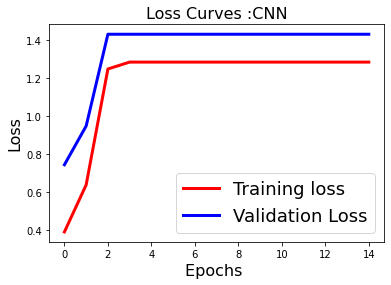

In [24]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
fig1.savefig('loss_cnn.png')
plt.show()

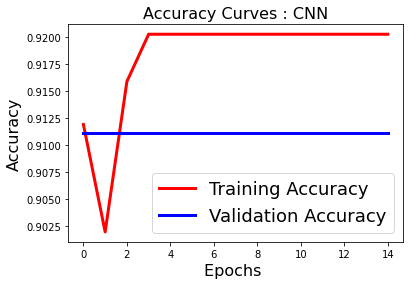

In [25]:
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : CNN',fontsize=16)
fig2.savefig('accuracy_cnn.png')
plt.show()

In [26]:
model.save("model_CNN.h5")
print("Saved model to disk")

Saved model to disk


**Recurrent Neural Network**


In [0]:
from keras.layers import LSTM

Here 256 is the dimensionality of output space

In [28]:
l_lstm_1 = LSTM(256)(embedded_sequences)
preds = Dense(2, activation='softmax')(l_lstm_1)

model2 = Model(sequence_input, preds)

model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model2.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         313400    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               365568    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 514       
Total params: 679,482
Trainable params: 679,482
Non-trainable params: 0
_________________________________________________________________
None


In [29]:
history2 = model2.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=10, batch_size=256,callbacks=[cp, tb_cb])

Train on 2520 samples, validate on 630 samples
Epoch 1/10
2520/2520 [==============================] - 185s 73ms/step - loss: 0.3200 - acc: 0.9024 - val_loss: 0.2662 - val_acc: 0.9111

Epoch 00001: val_acc did not improve from 0.91111
Epoch 2/10
2520/2520 [==============================] - 175s 70ms/step - loss: 0.2370 - acc: 0.9202 - val_loss: 0.2454 - val_acc: 0.9111

Epoch 00002: val_acc did not improve from 0.91111
Epoch 3/10
2520/2520 [==============================] - 180s 71ms/step - loss: 0.2085 - acc: 0.9218 - val_loss: 0.2235 - val_acc: 0.9159

Epoch 00003: val_acc improved from 0.91111 to 0.91587, saving model to model_cnn.hdf5
Epoch 4/10
2520/2520 [==============================] - 175s 69ms/step - loss: 0.1848 - acc: 0.9290 - val_loss: 0.2081 - val_acc: 0.9302

Epoch 00004: val_acc improved from 0.91587 to 0.93016, saving model to model_cnn.hdf5
Epoch 5/10
2520/2520 [==============================] - 176s 70ms/step - loss: 0.1609 - acc: 0.9409 - val_loss: 0.2032 - val_acc:

In [30]:
y_pred2 = model2.predict(x_val)
y_pred2 = np.argmax(y_pred2, axis=1)
y_pred2.shape



(630,)

In [31]:
y_val2 = np.argmax(y_val, axis=1)
y_val2.shape

(630,)

In [32]:
print(confusion_matrix(y_val2,y_pred2))

[[ 23  33]
 [ 11 563]]


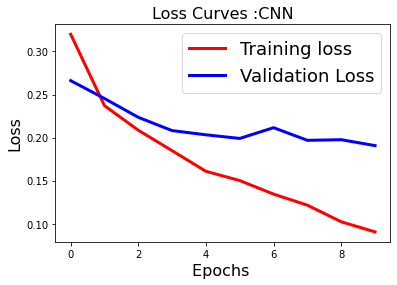

In [33]:
fig1 = plt.figure()
plt.plot(history2.history['loss'],'r',linewidth=3.0)
plt.plot(history2.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
fig1.savefig('loss_cnn.png')
plt.show()

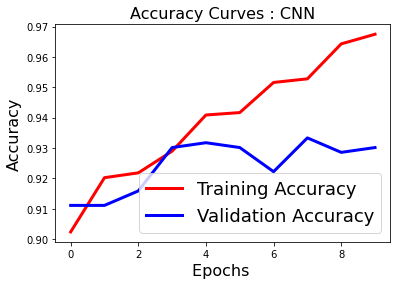

In [34]:
fig2=plt.figure()
plt.plot(history2.history['acc'],'r',linewidth=3.0)
plt.plot(history2.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : CNN',fontsize=16)
fig2.savefig('accuracy_cnn.png')
plt.show()

**Saving RNN model**


In [35]:
model2.save("model_RNN.h5")
print("Saved model to disk")

Saved model to disk
